# Automated label transfer with Cell2location

This script runs Cell2location - a spatial transcriptomics deconvolution method - to transfer labels from a single cell neuroblastoma atlas to spatial CosMx SMI profiling data of neuroblastoma tissue

Kleshchevnikov, V., Shmatko, A., Dann, E. et al. Cell2location maps fine-grained cell types in spatial transcriptomics. Nat Biotechnol (2022). https://doi.org/10.1038/s41587-021-01139-4 https://www.nature.com/articles/s41587-021-01139-4

In [1]:
# Packages
import scanpy as sc
import squidpy as sq
import numpy as np
import seaborn as sns
import pandas as pd
import cell2location as c2l
import matplotlib
import os
import scipy
import scipy.sparse
import matplotlib.pyplot as plt

from matplotlib import rcParams
from cycler import cycler
from cell2location.utils.filtering import filter_genes


# Settings
sc.settings.set_figure_params(dpi=80, facecolor="white")
rcParams['pdf.fonttype'] = 42
rcParams['figure.figsize'] = 6,6

/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
2024-08-05 18:43:16.735156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set up results directory
os.mkdir = '/project/data/gew123/Spatial/Deconvolution/Results_final'
results = '/project/data/gew123/Spatial/Deconvolution/Results_final'

In [3]:
# Creating paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results}/Reference_signatures'
run_name = f'{results}/Spatial_mapping'

## Cell2location label transfer

### (1) Generate gene signatures from atlas

Reading in the spatial and the reference data

In [30]:
# Spatial
adata_st = sc.read_h5ad('/project/data/gew123/Spatial/Objects/spatial_clustered_unlabelled.h5ad')
adata_st

AnnData object with n_obs × n_vars = 182735 × 1000
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'tissue', 'section', 'subtype', 'stage', 'cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'leiden_25_0.7', 'leiden_25_0.8', 'leiden_25_1.0'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'leiden_25_0.7_colors', 'leiden_25_0.8_colors', 'leiden_25_1.0_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', '

In [4]:
# Reference atlas
adata_sc = sc.read_h5ad('/project/data/gew123/Cell_Annotation/FINAL_ATLAS_OBJECTS/final_atlas_annotated.h5ad')
adata_sc

In [5]:
# Set raw counts
adata_sc.X = adata_sc.layers['raw_counts']

In [6]:
# Making sure reference data has integer count values

# Processing in chunks to avoid memory limits
def process_in_chunks(sparse_matrix, chunk_size=1000):
    # Number of rows in the matrix
    num_rows = sparse_matrix.shape[0]
    
    # Initialize a list to store the processed chunks
    processed_chunks = []
    
    for start in range(0, num_rows, chunk_size):
        end = min(start + chunk_size, num_rows)
        chunk = sparse_matrix[start:end, :].toarray()
        chunk_int = np.round(chunk).astype(int)
        processed_chunks.append(scipy.sparse.csr_matrix(chunk_int))
    
    # Concatenate all chunks back into a single sparse matrix
    return scipy.sparse.vstack(processed_chunks)

# Process the sparse matrix in chunks
sparse_matrix_int = process_in_chunks(adata_sc.X, chunk_size=1000)

# Update the AnnData object with the processed sparse matrix
adata_sc.X = sparse_matrix_int

/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 480x480 with 0 Axes>

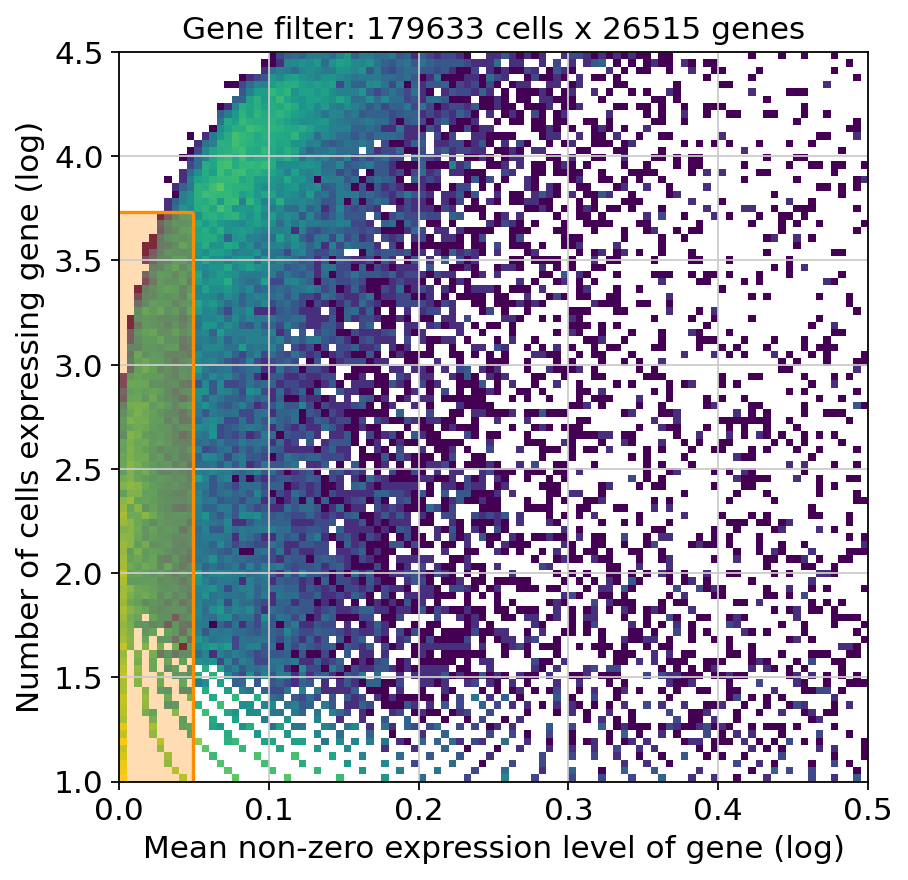

In [7]:
# Filter reference data
fig = plt.gcf()
selected = filter_genes(adata_sc, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
# Filter the object based on selected genes
adata_ref_fil = adata_sc[:, selected].copy()

In [8]:
# Save filtered reference
adata_ref_fil.write('/project/data/gew123/Spatial/Objects/Reference_c2l_filtered_FINAL.h5ad')

Model set up -- the next cell is ran in a separate python script that reads in the adata_ref_fil object we just saved

In [ ]:
# Prepare anndata for the regression model
c2l.models.RegressionModel.setup_anndata(adata=adata_ref_fil,
                        # 10X reaction / sample / batch
                        batch_key='Source',
                        # cell type, covariate used for constructing signatures
                        labels_key='manual_labels_new',
                       )

# Create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref_fil)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

# Train the model..... python script ran through terminal

Now checking the results:

In [4]:
# Read in model and results
adata_file = f"{ref_run_name}/reference_signatures.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = c2l.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File /project/data/gew123/Spatial/Deconvolution/Results_final/Reference_signatures/model.pt already       
         downloaded                                                                                                


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDa

Epoch 1/111:   1%|          | 1/111 [00:01<03:01,  1.65s/it, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/111:   1%|          | 1/111 [00:01<03:03,  1.67s/it, v_num=1]


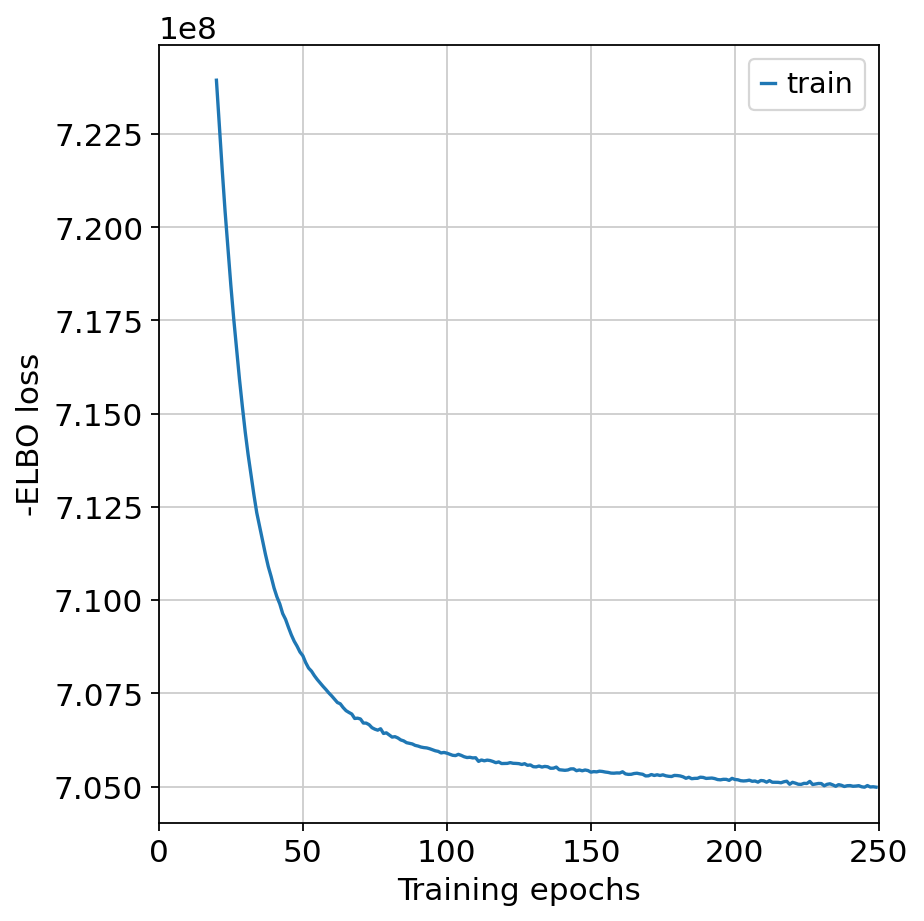

In [5]:
# Plotting model history
mod.plot_history(20)
plt.savefig('/project/data/gew123/Spatial/Figures/cell2location/c2l_pt1_elbo_FINAL.png')

In [6]:
if not hasattr(mod, 'samples'):
    # Reload the posterior samples from the AnnData object if available
    mod.samples = adata_ref.uns['mod']  # Adjust this based on how you saved the posterior

In [14]:
adata_ref

AnnData object with n_obs × n_vars = 180681 × 26631
    obs: 'Source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'leiden_res0.7', 'leiden_res0.9', 'manual_labels', 'manual_labels_final', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells', 'nonz_mean'
    uns: 'Source_colors', '_scvi_manager_uuid', '_scvi_uuid', 'dea_leiden_0.9', 'dendrogram_leiden_res0.9', 'hvg', 'leiden', 'leiden_res0.7_colors', 'leiden_res0.9_colors', 'manual_labels_colors', 'manu

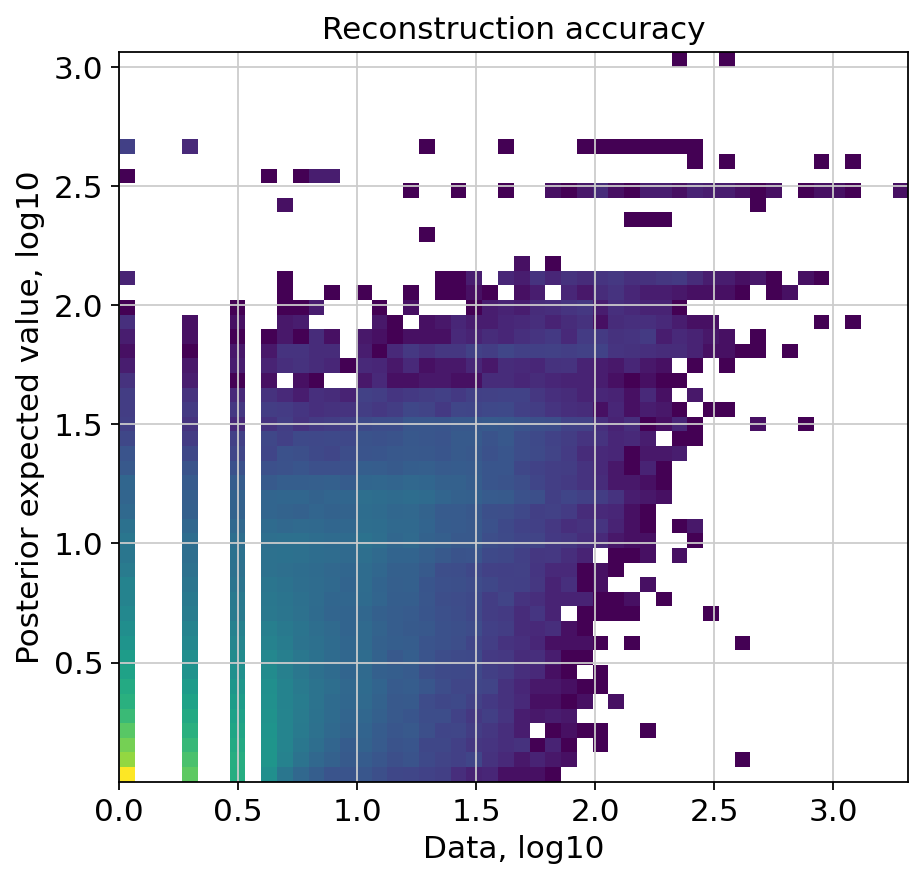

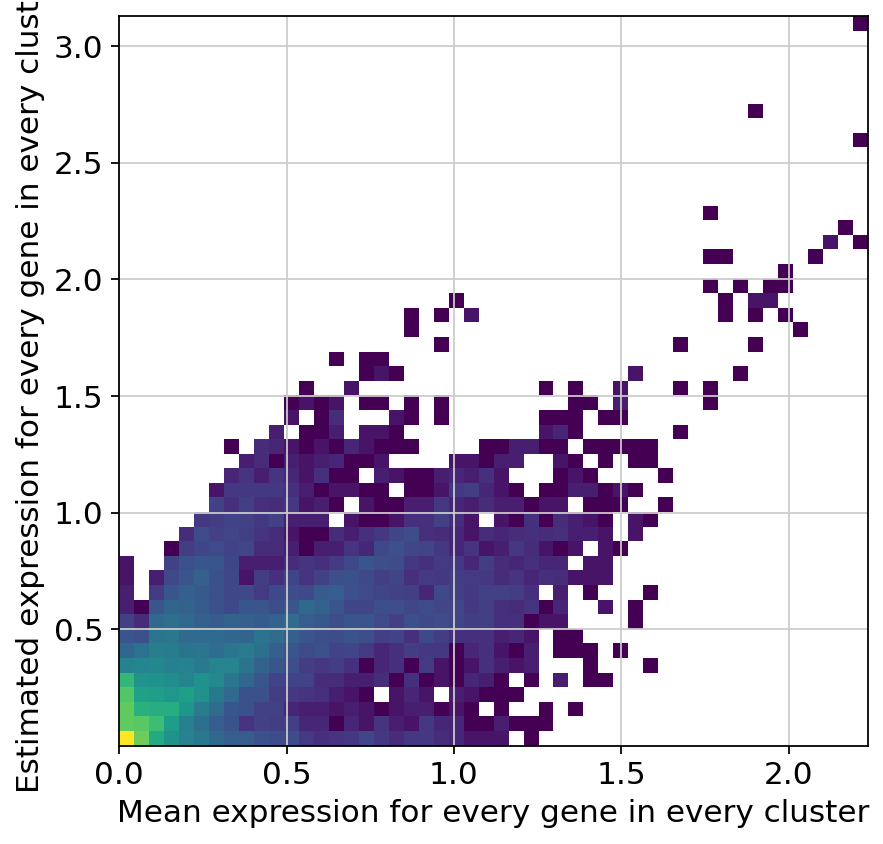

In [18]:
import matplotlib.pyplot as plt
mod.plot_QC()
plt.savefig('/project/data/gew123/Spatial/Figures/cell2location/c2l_part1_reconstruction_plot.png', dpi=400)

In [16]:
adata_ref.uns['mod']['factor_names']

array(['B cells', 'Cytotoxic (CD8+) T cells',
       'Cytotoxic (CD8+/IGKC+) T cells', 'Helper (CD4+) T cells',
       'Macrophages/monocytes', 'Mast cells', 'NK cells', 'Naïve T cells',
       'Plasma cells', 'Proliferating T cells',
       'Sympathetic neuronal/glial cells', 'Sympathetic neurons',
       'Neuroblasts', 'Mesenchymal cells', 'Chromaffin cells',
       'Endothelial cells', 'Bridge cells', 'Myofibroblasts', 'SCPs',
       'Hepatocytes', 'Adrenal cortex'], dtype=object)

In [20]:
# Extracting reference cell types signatures as a pd.DataFrame (inf_aver)

# For spatial mapping we just need the estimated expression of every gene in every cell type

# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B cells,Cytotoxic (CD8+) T cells,Cytotoxic (CD8+/IGKC+) T cells,Helper (CD4+) T cells,Macrophages/monocytes
7SK.2,0.000193,0.000080,0.000265,0.000190,0.000075
A1BG,0.050562,0.011787,0.007883,0.024171,0.076026
A1BG-AS1,0.013522,0.009932,0.005620,0.005067,0.013232
A1CF,0.000297,0.000095,0.000245,0.000502,0.000412
A2M,0.007099,0.012807,0.008092,0.007455,0.389863


### (2) Map gene signatures to spatial data

Spatial mapping is ran as a separate python script through the terminal /project/data/gew123/Spatial/Deconvolution/c2l_part2_script.py

In [ ]:
# Removed MT genes in spatial data
adata_st.var["MT_gene"] = [gene.startswith("MT-") for gene in adata_st.var_names]

# Remove genes
adata_st.obsm["MT"] = adata_st[:, adata_st.var["MT_gene"].values].X.toarray()
adata_st = adata_st[:, ~adata_st.var["MT_gene"].values]

In [ ]:
adata_st.obs['sample'] = list(adata_st.uns['spatial'].keys())[0]

In [24]:
# Find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_st.var_names, inf_aver.index)
adata_st = adata_st[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [25]:
# Set layer of log counts
adata_st.layers['log_counts'] = adata_st.X

# Bring raw counts to top
adata_st.X = adata_st.layers['counts']

In [27]:
# Prepare anndata for cell2location model
c2l.models.Cell2location.setup_anndata(adata=adata_st, batch_key="tissue")

In [29]:
# Create model
mod = c2l.models.Cell2location(
    adata_st, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1, # 1 because working with single cell spatial data
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)

In [1]:
# Python script runs model training

Checking cell label predictions

In [4]:
# Reload in model and adata object
adata_file = f"{run_name}/c2l_label_predications.h5ad"
adata_st = sc.read_h5ad(adata_file)

# Read in model
mod = c2l.models.Cell2location.load(f"{run_name}", adata_st)

INFO     File /project/data/gew123/Spatial/Deconvolution/Results_final/Spatial_mapping/model.pt already downloaded 


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDa

Epoch 1/30000:   0%|          | 1/30000 [00:03<26:17:40,  3.16s/it, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:03<26:34:54,  3.19s/it, v_num=1]


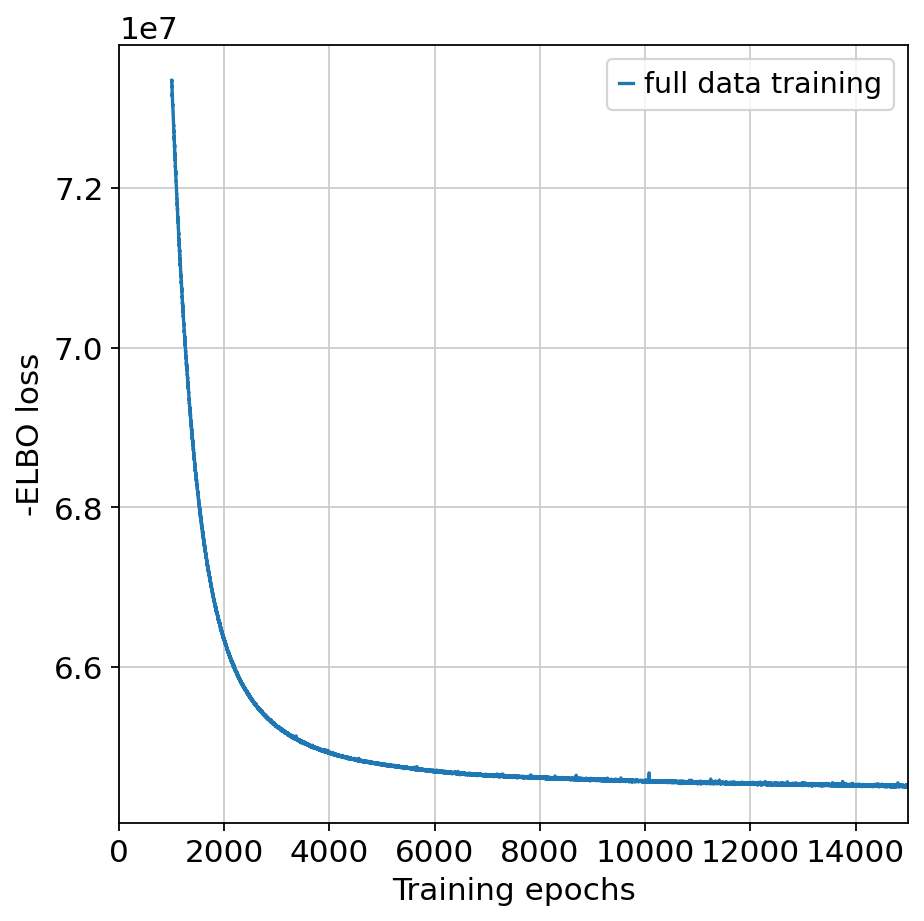

In [5]:
# Plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])
plt.tight_layout()
plt.savefig('/project/data/gew123/Spatial/Deconvolution/Figures/c2l_plots_final.png')

In [6]:
if not hasattr(mod, 'samples'):
    # Reload the posterior samples from the AnnData object if available
    mod.samples = adata_st.uns['mod']  # Adjust this based on how you saved the posterior

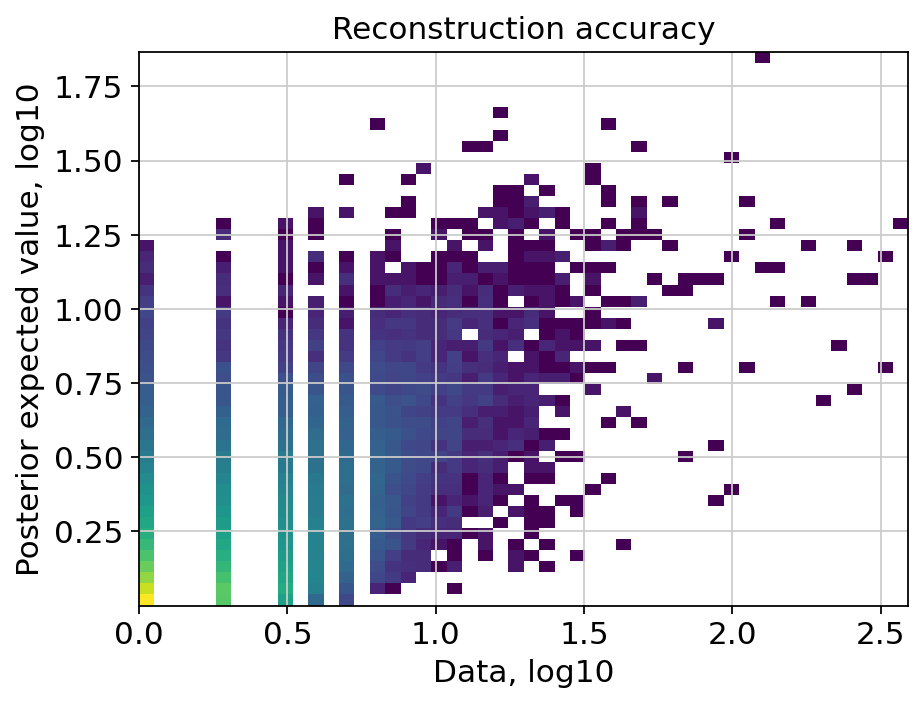

In [7]:
import matplotlib.pyplot as plt
mod.plot_QC()
plt.savefig('/project/data/gew123/Spatial/Deconvolution/Figures/c2l_part2_reconstruction_plot.png', dpi=400)

In [8]:
# Extract predictions
adata_st.obs[adata_st.uns['mod']['factor_names']] = adata_st.obsm['q05_cell_abundance_w_sf']

In [9]:
cell_type_columns = adata_st.uns['mod']['factor_names']
cell_abundance_df = adata_st.obs[cell_type_columns]

# Step 2: Find the cell type with the highest abundance for each cell
# This will give you a Series where each value is the name of the cell type with the highest quantile for that cell
most_appropriate_cell_type = cell_abundance_df.idxmax(axis=1)

adata_st.obs['c2l_predicted'] = most_appropriate_cell_type

In [10]:
adata_st.obs["c2l_predicted"].value_counts()

Mast cells                        21229
Macrophages/monocytes             19158
Bridge cells                      16700
Late neuroblasts                  13443
Chromaffin cells                  13069
Myofibroblasts                    13015
Mesenchymal cells                 12084
Endothelial cells                 11960
SCPs                              10820
B cells                            9457
Adrenal cortex                     9403
Neuroblasts                        9182
Plasma cells                       5385
Connecting progenitor cells        4947
Helper (CD4+) T cells              4464
NK cells                           3599
Naïve T cells                      2172
Cytotoxic (CD8+) T cells           1350
Cytotoxic (CD8+/IGKC+) T cells     1085
Proliferating T cells               213
Name: c2l_predicted, dtype: int64

In [156]:
adata_st.obs

,fov,Area,AspectRatio,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,...,Neuroblasts,Mesenchymal cells,Chromaffin cells,Endothelial cells,Bridge cells,Myofibroblasts,SCPs,Hepatocytes,Adrenal cortex,c2l_predicted
3_1,1,10996,2.06,95170.997899,99963.034702,183,89,52,4561,37,...,0.006736,0.002399,0.022079,0.014064,0.018664,0.049447,0.008066,0.379096,0.007580,Hepatocytes
5_1,1,9341,0.82,95468.997899,99760.034702,102,124,332,2770,341,...,0.001670,0.002536,0.004491,0.260514,0.005809,0.006179,0.002537,0.002363,0.009135,Endothelial cells
6_1,1,4901,1.26,95379.997899,99721.034702,92,73,340,692,867,...,0.002056,0.377220,0.003808,0.006880,0.005062,0.023329,0.005377,0.004137,0.003001,Mesenchymal cells
7_1,1,8042,0.76,95249.997899,99688.034702,93,123,380,1287,618,...,0.000430,0.000355,0.001626,0.000617,0.003490,0.000467,0.000783,0.000718,0.001061,Mast cells
8_1,1,3137,0.72,95412.997899,99681.034702,63,87,569,1201,915,...,0.004927,0.001996,0.004909,0.071027,0.016800,0.002372,0.004232,0.098735,0.012663,Hepatocytes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471_202,202,4170,0.92,81967.003876,56219.283252,82,89,2288,14766,404,...,0.002951,0.037159,0.016062,0.017717,0.009285,0.002879,0.007724,0.020825,0.005900,Helper (CD4+) T cells
473_202,202,4561,1.39,82186.003876,56182.283252,97,70,3171,17822,511,...,0.022137,0.008833,0.042351,0.022897,0.047565,0.018309,0.011039,0.039606,0.031826,Macrophages/monocytes
474_202,202,6188,1.43,82094.003876,56138.283252,109,76,3346,16071,405,...,0.003297,0.001131,0.008449,0.001024,0.012531,0.024299,0.001637,0.001997,0.002771,Myofibroblasts
475_202,202,4717,1.08,81896.003876,56118.283252,81,75,2092,13187,438,...,0.003004,0.001756,0.067140,0.015154,0.007023,0.032707,0.054816,0.001814,0.003728,Chromaffin cells


In [11]:
# Group into broad biological categories and save to adata.obs

# Fine groupings
grouping_rules = {
    'T cells': ['Cytotoxic (CD8+) T cells', 'Cytotoxic (CD8+/IGKC+) T cells', 'Naïve T cells', 
               'Helper (CD4+) T cells', 'NK cells', 'Proliferating T cells'],
    'B cells': ['B cells', 'Plasma cells'],
    'Myeloid cells': ['Macrophages/monocytes', 'Mast cells'],
    'Neuroblasts': ['Neuroblasts', 'Late neuroblasts']

}

# Broader groupings
grouping_rules2 =  {
    'Immune': ['Cytotoxic (CD8+) T cells', 'Cytotoxic (CD8+/IGKC+) T cells', 'Naïve T cells', 
               'Helper (CD4+) T cells', 'NK cells', 'Proliferating T cells', 'Macrophages/monocytes',
               'Mast cells', 'B cells', 'Plasma cells'],
    'Sympathoadrenal': ['Neuroblasts', 'Late neuroblasts', 'Chromaffin cells', 'Bridge cells',
                        'Connecting progenitor cells'],
}

# Function to map cell types to grouped annotations based on the provided rules
def map_to_group(cell_type, rules):
    for group, types in rules.items():
        if cell_type in types:
            return group
    # Return original cell type if no group is found
    return cell_type

# Apply the function to create a new column for grouped annotations
adata_st.obs['grouped_annotations'] = adata_st.obs['c2l_predicted'].apply(lambda x: map_to_group(x, grouping_rules))
adata_st.obs['grouped_annotations2'] = adata_st.obs['c2l_predicted'].apply(lambda x: map_to_group(x, grouping_rules2))

adata_st.obs

,fov,Area,AspectRatio,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,...,Myofibroblasts,NK cells,Naïve T cells,Neuroblasts,Plasma cells,Proliferating T cells,SCPs,c2l_predicted,grouped_annotations,grouped_annotations2
3_1,1,10996,2.06,95170.997899,99963.034702,183,89,52,4561,37,...,0.058966,0.056750,0.027504,0.009180,0.017312,0.024889,0.012299,Mast cells,Myeloid cells,Immune
5_1,1,9341,0.82,95468.997899,99760.034702,102,124,332,2770,341,...,0.005610,0.101589,0.006205,0.002211,0.000934,0.005424,0.002523,Endothelial cells,Endothelial cells,Endothelial cells
6_1,1,4901,1.26,95379.997899,99721.034702,92,73,340,692,867,...,0.032203,0.009549,0.003304,0.001436,0.061969,0.003653,0.004397,Mesenchymal cells,Mesenchymal cells,Mesenchymal cells
7_1,1,8042,0.76,95249.997899,99688.034702,93,123,380,1287,618,...,0.000541,0.001696,0.003747,0.000495,0.001102,0.002184,0.000731,Mast cells,Myeloid cells,Immune
8_1,1,3137,0.72,95412.997899,99681.034702,63,87,569,1201,915,...,0.002241,0.005317,0.005936,0.005192,0.001642,0.004909,0.004984,Endothelial cells,Endothelial cells,Endothelial cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471_202,202,4170,0.92,81967.003876,56219.283252,82,89,2288,14766,404,...,0.002689,0.018653,0.009173,0.002592,0.003620,0.014855,0.006757,Helper (CD4+) T cells,T cells,Immune
473_202,202,4561,1.39,82186.003876,56182.283252,97,70,3171,17822,511,...,0.018522,0.061767,0.043614,0.016903,0.051942,0.038063,0.008358,Macrophages/monocytes,Myeloid cells,Immune
474_202,202,6188,1.43,82094.003876,56138.283252,109,76,3346,16071,405,...,0.029221,0.004342,0.005389,0.001597,0.004337,0.004464,0.001264,Myofibroblasts,Myofibroblasts,Myofibroblasts
475_202,202,4717,1.08,81896.003876,56118.283252,81,75,2092,13187,438,...,0.044673,0.004349,0.010225,0.004691,0.000795,0.005944,0.057576,SCPs,SCPs,SCPs


In [30]:
# Cleaning up label names
for i in adata_st.obs['grouped_annotations'].unique():
    if ' cells' in i:
        if i != 'B cells' and i != 'T cells' and i != 'Myeloid cells' and i != 'Plasma cells' and i != 'Connecting progenitor cells':
            new_label = i[0:len(i)-6]
            adata_st.obs['grouped_annotations'] = adata_st.obs['grouped_annotations'].replace(i, new_label)

adata_st.obs['grouped_annotations'].unique()

['Myeloid cells', 'Endothelial', 'Mesenchymal', 'Bridge', 'T cells', ..., 'Chromaffin', 'Myofibroblasts', 'Neuroblasts', 'Connecting progenitor', 'SCPs']
Length: 12
Categories (12, object): ['Adrenal cortex', 'B cells', 'Bridge', 'Chromaffin', ..., 'Myofibroblasts', 'Neuroblasts', 'SCPs', 'T cells']

In [25]:
# Repeat label clean up for broad groups
for i in adata_st.obs['grouped_annotations2'].unique():
    if ' cells' in i:
        if i != 'Immune cells':
            new_label = i[0:len(i)-6]
            adata_st.obs['grouped_annotations2'] = adata_st.obs['grouped_annotations2'].replace(i, new_label)

In [32]:
adata_st.obs['grouped_annotations'].value_counts()

Myeloid cells            40387
Neuroblasts              22625
Bridge                   16700
B cells                  14842
Chromaffin               13069
Myofibroblasts           13015
T cells                  12883
Mesenchymal              12084
Endothelial              11960
SCPs                     10820
Adrenal cortex            9403
Connecting progenitor     4947
Name: grouped_annotations, dtype: int64

In [31]:
adata_st.obs['grouped_annotations2'].value_counts()

Immune             68112
Sympathoadrenal    57341
Myofibroblasts     13015
Mesenchymal        12084
Endothelial        11960
SCPs               10820
Adrenal cortex      9403
Name: grouped_annotations2, dtype: int64

In [178]:
# These are old annotations
adata_st.obs['grouped_annotations2'].value_counts()

Sympathoadrenal    60074
Immune cells       51452
Mesenchymal        22143
Hepatocytes        13923
Myofibroblasts     13728
Endothelial        11181
Bridge              5719
Adrenal cortex      4515
Name: grouped_annotations2, dtype: int64

Plot annotated UMAP

In [33]:
# Confirming raw counts are set
print(adata_st.X[1:100,1:100])

  (0, 54)	1
  (0, 63)	1
  (0, 77)	1
  (0, 96)	3
  (1, 64)	1
  (1, 77)	2
  (1, 96)	5
  (2, 77)	1
  (3, 1)	1
  (3, 36)	2
  (5, 11)	2
  (5, 22)	2
  (5, 30)	1
  (5, 32)	1
  (5, 46)	1
  (5, 48)	2
  (5, 65)	1
  (5, 68)	1
  (5, 77)	1
  (5, 81)	2
  (5, 89)	1
  (5, 92)	3
  (5, 94)	1
  (5, 96)	1
  (6, 17)	2
  :	:
  (93, 16)	1
  (93, 36)	2
  (93, 42)	1
  (93, 68)	1
  (93, 76)	1
  (93, 81)	1
  (93, 92)	2
  (94, 7)	1
  (94, 73)	1
  (95, 22)	2
  (95, 68)	1
  (95, 73)	1
  (95, 87)	1
  (95, 89)	1
  (95, 96)	1
  (95, 98)	1
  (96, 87)	1
  (96, 95)	1
  (96, 96)	1
  (97, 2)	1
  (97, 14)	1
  (97, 33)	1
  (97, 84)	2
  (98, 2)	2
  (98, 98)	1


/tmp/ipykernel_1255467/130974450.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Grouped Annotations', y='Counts', data=counts_df, palette=colors)


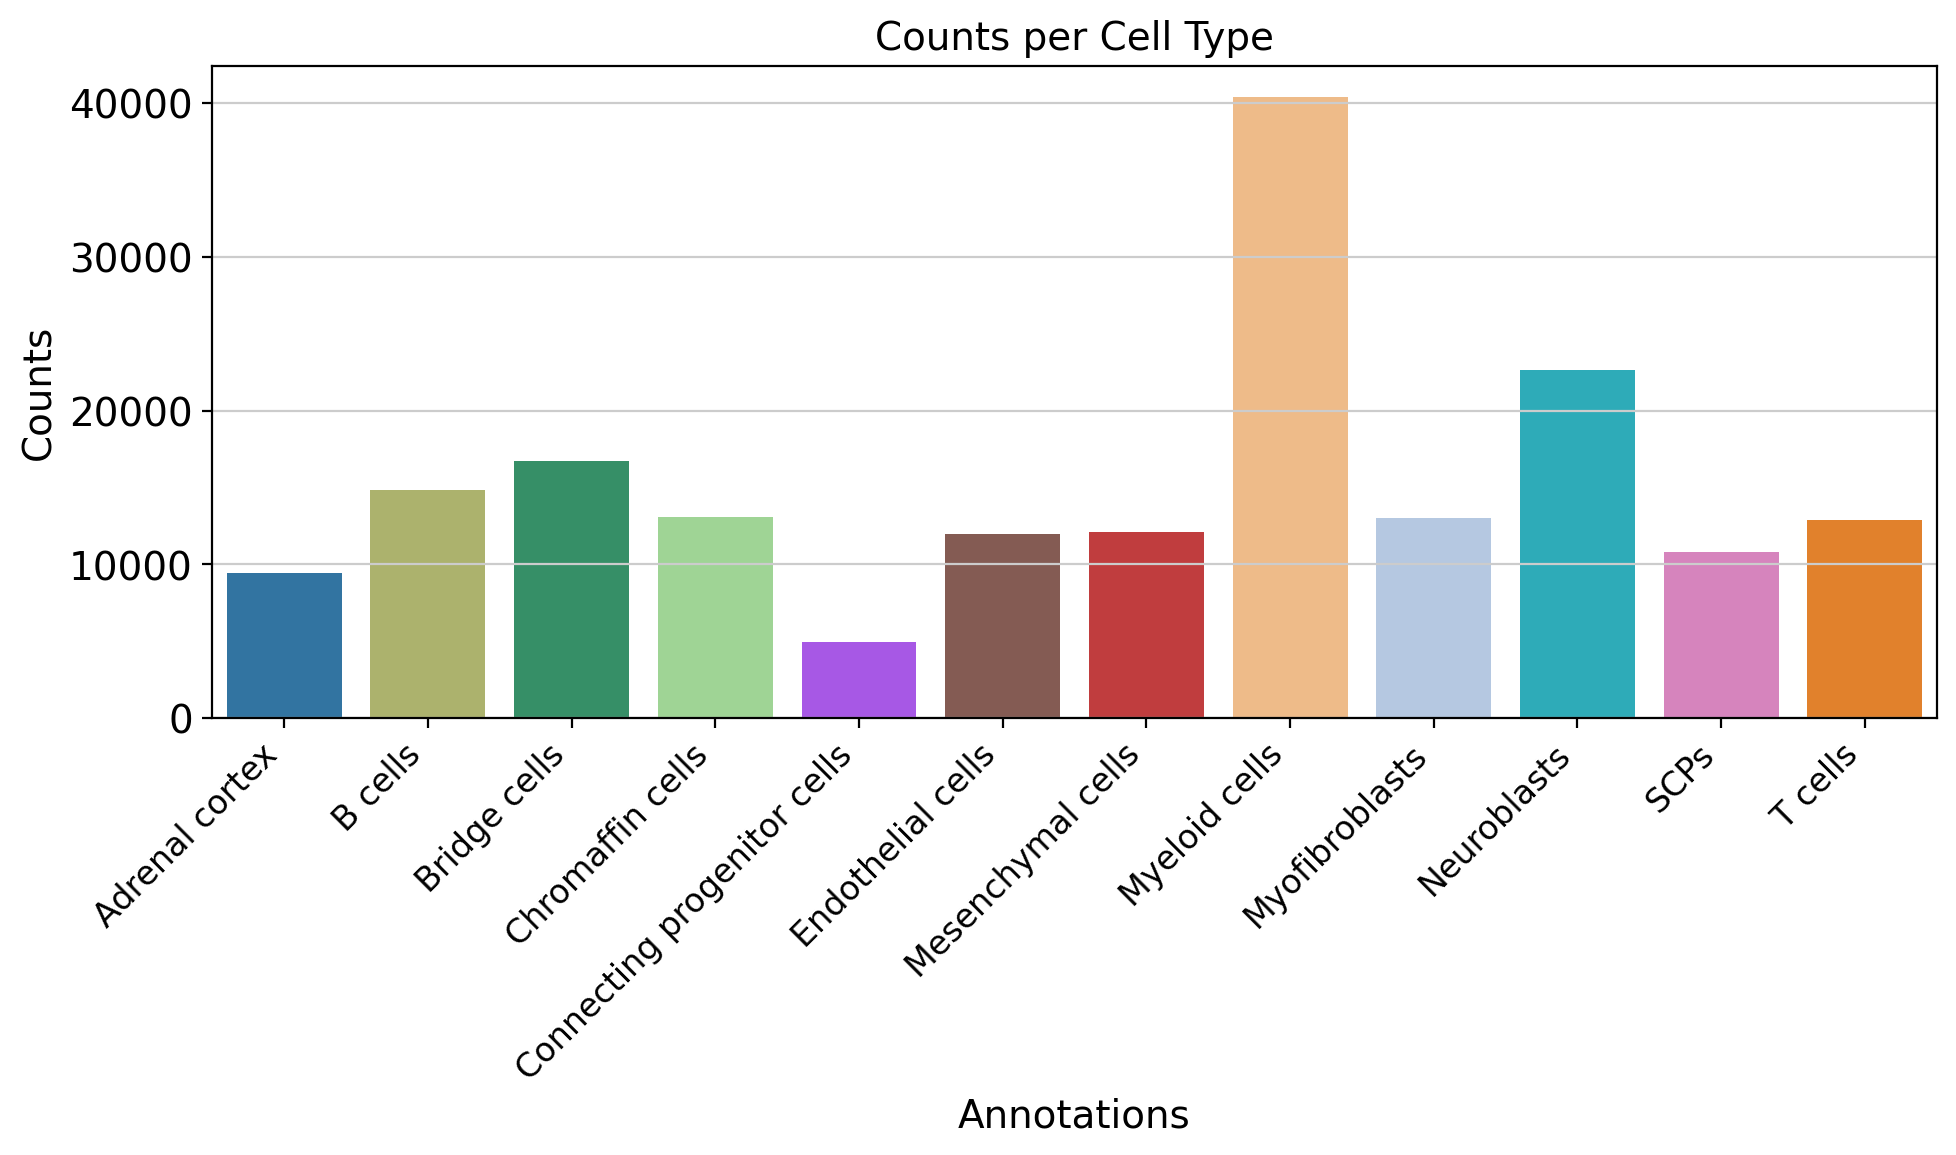

In [20]:
# Checking cell distribution results

grouped_annotations_colors = adata_st.uns['grouped_annotations_colors']

# Generate barplot of cell counts

# Get the counts of each annotation and convert to DataFrame
counts = adata_st.obs["grouped_annotations"].value_counts()
counts_df = counts.reset_index()
counts_df.columns = ['Grouped Annotations', 'Counts']

# Map the colormap to the counts DataFrame
color_map = dict(zip(adata_st.obs['grouped_annotations'].cat.categories, grouped_annotations_colors))
counts_df = counts_df.set_index('Grouped Annotations').reindex(adata_st.obs['grouped_annotations'].cat.categories).reset_index()

colors = counts_df['Grouped Annotations'].map(color_map).tolist()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Grouped Annotations', y='Counts', data=counts_df, palette=colors)

# Customize the plot
plt.title('Counts per Cell Type')
plt.xlabel('Annotations')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
#plt.savefig('/project/data/gew123/Spatial/Figures/c2l_counts_per_cell_type_final.png')

# Show the plot
plt.show()

In [34]:
# Save c2l labelled object here:
adata_st.write('/project/data/gew123/Spatial/Annotated_objects/spatial_c2l_annotated_final.h5ad')